In [1]:
import numpy as np
import torch
import trimesh
from scipy.stats import trim_mean

import torch

def sample_mesh(verts, faces, sample_count:int=2000):
    with torch.no_grad():
        # --- 1. Area-weighted surface sampling
        v0, v1, v2 = verts[faces].unbind(1)  # (F, 3) each
        face_areas = 0.5 * (v1 - v0).cross(v2 - v0, dim=1).norm(dim=1)  # (F,)
        sum_face_areas = face_areas.sum()
        probs = face_areas / sum_face_areas
        face_idx = torch.multinomial(probs, sample_count, replacement=True)

        device = verts.device
        dtype = verts.dtype
        u = torch.rand(sample_count, 1, device=device, dtype=dtype)
        v = torch.rand(sample_count, 1, device=device, dtype=dtype)

        eps = 1e-6
        mask = (u + v) > (1 - eps)
        u[mask] = 1 - u[mask]
        v[mask] = 1 - v[mask]
        w = 1 - (u + v)

        sampled_pts = (
            w * v0[face_idx] +
            u * v1[face_idx] +
            v * v2[face_idx]
        )  # (N, 3)
        return sampled_pts.float()



def preprocess_pointcloud(
    verts_ori:torch.Tensor,
    verts_remesh:torch.Tensor,
    sampled_pts: torch.Tensor, 
    prints=False
    #faces: torch.Tensor, 
    #sample_count: int = 8000
) -> torch.Tensor:
    """
    Preprocess a mesh by sampling surface points and applying PCA-based orientation,
    unit-area scaling, and mesh-bounding-box centering.

    Steps:
    
    2. Compute PCA on sampled points in PyTorch to find principal axes.
    3. Enforce consistent axis signs so anatomical extremes lie in + direction.
    4. Align both mesh and point cloud to principal axes.
    5. Scale both to 1.7 surface area bounding box.

    Returns:
        torch.Tensor: Sampled point cloud of shape (sample_count, 3),
                      rotated, scaled, and centered.
    """
    with torch.no_grad():
        
        sample_count = sampled_pts.shape[0]
        # --- 2. PCA orientation (based on sampled points)
        mean_pt = sampled_pts.mean(dim=0)
        centered = sampled_pts - mean_pt
        #if(prints):
        #    print(centered[:10])
        cov = centered.T @ centered / (sample_count - 1)
        #if(prints):
        #    print(cov)
        eigvals, eigvecs = torch.linalg.eigh(cov)
        for i in range(3):  # for each eigenvector
            if eigvecs[0, i] < 0:
                eigvecs[:, i] *= -1

        #if(prints):
        #    print(eigvals, eigvecs)
        order = torch.argsort(eigvals, descending=True)
        axes = eigvecs[:, order]  # (3, 3)
        #if(prints):
        #    print(axes)
        # --- 3. Enforce consistent axis signs
        proj = centered @ axes
        for i in range(2):
            if torch.median(proj[:, i]) < 0:
                axes[:, i] *= -1
        axes[:, 2] = torch.cross(axes[:, 0], axes[:, 1], dim=0)
            #else:
                #print(1)
                #print(torch.median(proj[:, i]))

        R = axes.T  # Rotation matrix (3,3)

        # --- 4. Rotate, center and scale mesh and point cloud
        verts_remesh = (R @ (verts_remesh - mean_pt).T).T
        verts_ori = (R @ (verts_ori - mean_pt).T).T
        sampled_pts = (R @ (sampled_pts - mean_pt).T).T
        #print(sampled_pts[:10])

        #scale_init = 1.0 / torch.sqrt(sum_face_areas)

        min_pt, _ = sampled_pts.min(dim=0)
        max_pt, _ = sampled_pts.max(dim=0)
        dims = max_pt - min_pt
        area = 2 * (dims[0]*dims[1] + dims[1]*dims[2] + dims[2]*dims[0])
        scale = 1.7 / torch.sqrt(area)
        

        verts_remesh *= scale
        sampled_pts *= scale
        verts_ori *= scale
        #print(sampled_pts[:10])

        

        
    return sampled_pts, verts_remesh, verts_ori, scale.item()

def preprocess_mesh(vertices, verts_remesh,face_remesh, sample_counts = 2000):
    sampled_pts = sample_mesh(verts_remesh,face_remesh, sample_counts)
    sampled_pts, verts_remesh, verts_ori, scale = preprocess_pointcloud(vertices,verts_remesh,sampled_pts, prints=False)
    return sampled_pts, verts_remesh, verts_ori, scale
    
    




In [2]:
import numpy as np
from trimesh.voxel import creation
def extract_center(arr, A, B, C):
    # Get the original shape (100, 100, 100 in this case)
    D, E, F = arr.shape  

    # Compute starting and ending indices for slicing
    start_x = (D - A) // 2
    start_y = (E - B) // 2
    start_z = (F - C) // 2

    end_x = start_x + A
    end_y = start_y + B
    end_z = start_z + C

    # Extract the centered sub-array
    return arr[start_x:end_x, start_y:end_y, start_z:end_z]


In [7]:
import pymeshlab
import tempfile
import os
import random
# Assume you already have mesh0 as a trimesh.Trimesh object
# Step 1: Save mesh0 to a temporary .ply file
def remesh(mesh0):
    with tempfile.NamedTemporaryFile(suffix='.ply', delete=False) as temp_file:
        mesh0.export(temp_file.name)
        temp_path = temp_file.name
    
    # Step 2: Load into pymeshlab
    ms = pymeshlab.MeshSet()
    ms.load_new_mesh(temp_path)
    #iter = 
    ms.apply_filter(
        'meshing_isotropic_explicit_remeshing',
        iterations=random.randint(1,3),
        adaptive=False,              # uniform remeshing
        targetlen=pymeshlab.PercentageValue(random.uniform(0.3,1.5)),               # 1% of bounding box diagonal
        #featuredeg=30.0,
        #checksurfdist=True,
        #maxsurfdist=1.0,             # 1% surface distance tolerance
        #splitflag=True,
        #collapseflag=True,
        #swapflag=True,
        #smoothflag=True,
        #reprojectflag=True
    )

    remeshed = ms.current_mesh()
    vertices = remeshed.vertex_matrix()  # (N, 3)
    faces = remeshed.face_matrix()      # (M, 3)

    # Step 4: Clean up temp file
    os.remove(temp_path)

    return vertices, faces

In [4]:
from scipy.spatial.transform import Rotation as R_scipy
# Load data and initialize shared parameters
import numpy as np
center = [0, 0, 0]
maxbounds = np.array([-100, -100, -100])
minbounds = np.array([100, 100, 100])
allshapes = meshori = np.load("data_8K_surreal.npz")['arr_0']
def process_single_shape(i):
    #pca = allshapes[i]
    mesh_tri = allshapes[i]#meanFace.T + np.dot(s_i.T, pca)
    random_rotation = R_scipy.random()
    rotation_matrix = random_rotation.as_matrix()
    mesh_tri = trimesh.Trimesh(vertices=mesh_tri, faces=faces)
    mesh_tri.vertices = (rotation_matrix @ mesh_tri.vertices.T).T
    
    remeshed_vert, remeshed_faces = remesh(mesh_tri)
    remeshed = trimesh.Trimesh(vertices = remeshed_vert,faces = remeshed_faces)
    areainit = remeshed.area
    #scaleinit = 1.0/np.sqrt(areainit)
    sampled_pts, verts_aligned, verts_ori, scale = preprocess_mesh(torch.tensor(mesh_tri.vertices).float(), torch.tensor(remeshed_vert).float(),torch.tensor(remeshed_faces)) 
    mesh_tri = trimesh.Trimesh(vertices = verts_aligned.numpy(), faces = np.array(remeshed_faces))
    #print(mesh_tri.area)
    #scale = scale/scaleinit
    voxel_grid = creation.local_voxelize(mesh_tri, np.array(center), 0.02, 60).fill()

    pointsidx = np.where(voxel_grid.matrix == True)
    pointsidx = np.stack((pointsidx[0], pointsidx[1], pointsidx[2])).T
    maxbounds_mesh = np.max(pointsidx, axis=0)
    minbounds_mesh = np.min(pointsidx, axis=0)

    voxel_grid_truncate = extract_center(voxel_grid.matrix, 119, 119, 119)
    voxel_grid_truncate = voxel_grid_truncate.astype(np.int8)
    del voxel_grid, mesh_tri
    return voxel_grid_truncate, sampled_pts.float().numpy(), verts_ori.float().numpy(), scale, maxbounds_mesh, minbounds_mesh, areainit
    #return mesh_tri.vertices, pts

In [8]:
import trimesh
faces = trimesh.load("template.ply", process=False).faces
mesh = trimesh.Trimesh(vertices=allshapes[0],faces=faces)
mesh.show()

In [9]:
import numpy as np
import trimesh
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R_scipy
import pickle
#with open("smal_CVPR2017.pkl", "rb") as f:
#    smal = pickle.load(f, encoding="latin1")
#    faces = smal['f']
#mesh= process_single_shape(0)
results = Parallel(n_jobs=-1)(delayed(process_single_shape)(i) for i in tqdm(range(len(allshapes))))


 90%|██████████████████████████████████████████████████████████████████████▏       | 7200/8000 [40:27<04:23,  3.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [45:04<00:00,  2.96it/s]


In [10]:
print(results.min(axis =0)[0]) #Minbounds, maxbounds on meshes
print(results.max(axis =0)[0])

tensor([-1.1368, -0.5576, -0.3440], dtype=torch.float64)
tensor([1.0426, 0.5548, 0.3421], dtype=torch.float64)


In [11]:
voxels_all, pts_all, verts_ori, scale_all,maxbounds, minbounds, areainit = zip(*results)



scale_all = np.array(scale_all)
maxbounds = np.max(np.stack(maxbounds), axis=0)
minbounds = np.min(np.stack(minbounds), axis=0)

print(minbounds)
print(maxbounds)

[ 9 31 39]
[110  88  85]


In [12]:
verts_ori = np.array(verts_ori)
np.savez_compressed("SurrealVertices_UDFFromPointCloud.npz", verts_ori)

In [13]:
verts_ori.shape

(8000, 6890, 3)

In [10]:
del verts_ori

In [14]:
np.save("ScaleSurrealFromUnitAreaMesh_UDFPointCloud.npz", scale_all)

In [15]:
#voxels_all = np.array(voxels_all)
pts_all = np.array(pts_all)

In [16]:
np.savez_compressed("SurrealPointCloudUDFFromPoitCloud.npz", pts_all)

In [17]:
del pts_all

In [18]:
voxels_all = np.array(voxels_all)

In [19]:
voxels_all.shape

(8000, 119, 119, 119)

In [20]:
del allshapes

In [21]:
np.savez_compressed("SurrealVoxelsPointCloudUDF.npz", voxels_all)

In [22]:
scale_all.shape

(8000,)

In [2]:
import numpy as np
voxels_all = np.load("C:\Research\Datasets\smal_online_V1.0\VoxelsPointCloudUDF.npz")['arr_0']

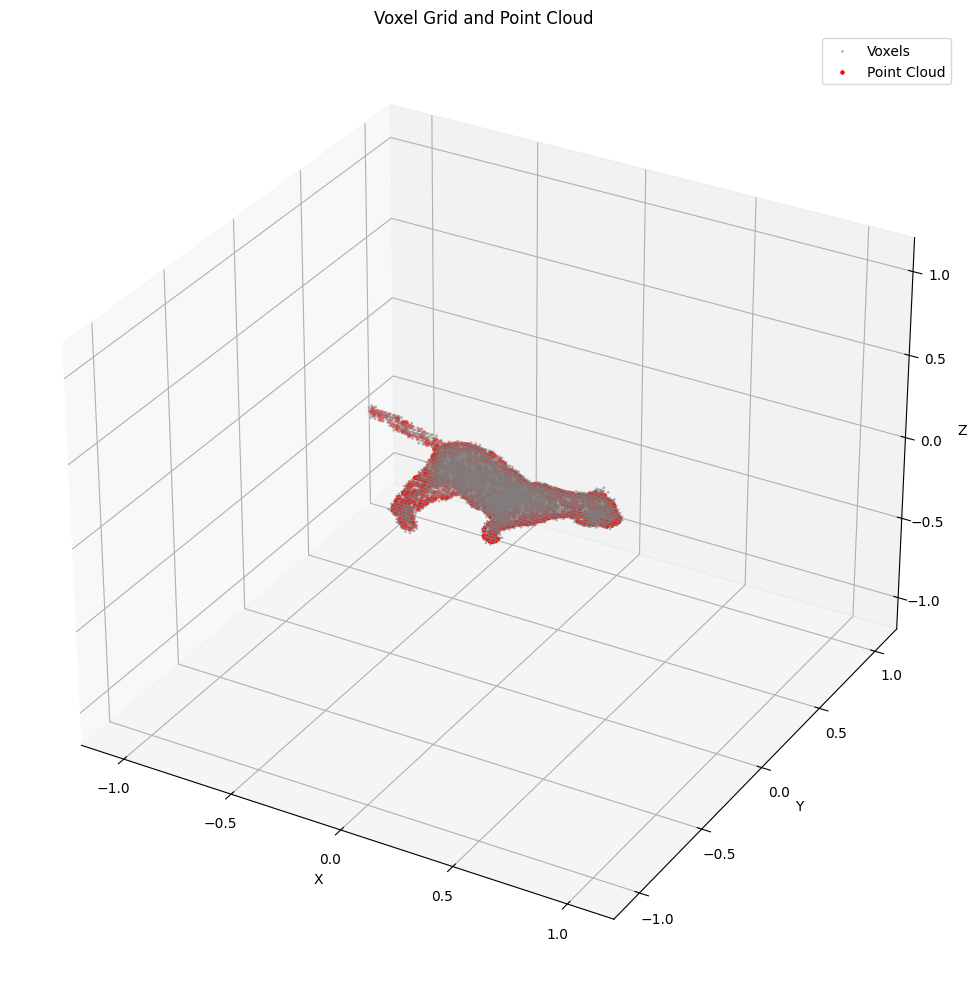

In [3]:
from vedo import Volume, Points, show
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Assume your data:
voxels = voxels_all[20]  # shape: (119, 119, 119), dtype: uint8 or bool
point_cloud = np.load("PointCloudUDFFromPoitCloud.npz")['arr_0'][20]   # shape: (N, 3)
verts = point_cloud#np.load("SMALVertices_UDFFromPointCloud.npz")['arr_0'][20]
# Parameters
grid_size = voxels.shape[0]
cell_size = 0.02
center_index = grid_size // 2

# Convert voxel indices to world coordinates
voxel_indices = np.argwhere(voxels > 0)  # shape: (N_voxels, 3)
voxel_coords = (voxel_indices - center_index) * cell_size  # center at (0, 0, 0)

# Plot using matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot voxels
ax.scatter(voxel_coords[:, 0], voxel_coords[:, 1], voxel_coords[:, 2],
           s=1, alpha=0.5, c='gray', label='Voxels')

 #Plot point cloud
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2],
           s=5, c='red', label='Point Cloud')

# Centered view
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_zlim(-1.2, 1.2)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Voxel Grid and Point Cloud")
ax.legend()
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
voxels_all = np.load("SurrealVoxelsPointCloudUDF.npz")['arr_0']


In [24]:
trainidx = np.load("SurrealTrainIndexPairs.npy")
trainidx = trainidx[np.where(trainidx < 12000)]
print(trainidx.shape)
voxels_all_train = voxels_all[trainidx]
del voxels_all
from tqdm import tqdm
std = []
mean = []
voxels_all_train = voxels_all_train.reshape(trainidx.shape[0], -1)
for i in tqdm(range(voxels_all_train.shape[1])):
    std.append(np.std(voxels_all_train[:,i]))
    mean.append(np.mean(voxels_all_train[:,i]))


(7800,)



100%|██████████████████████████████████████████████████████████████████████| 1685159/1685159 [07:50<00:00, 3580.44it/s]


In [25]:
#print(np.argsort(std))
std = np.array(std)
np.save("SurrealSTDdata_voxels_pointcloud_UDF.npy", std)
np.save("SurrealMeandata_voxels_pointcloud_UDF.npy", np.array(mean))
print(np.sum(std < 0.16))
indexinclude = np.where(std > 0.16)
print(indexinclude[0].shape)
#print(indexinclude)
print(np.median(std))
#vox_all = vox_all.reshape(vox_all.shape[0], -1)
#voxels_all_filter = vox_all[:,indexinclude[0]]
#voxels_all_filter.shape
#del vox_all
#del voxels_all_train

1660607
(24552,)
0.0


In [1]:
import numpy as np

# Assume these are numpy arrays of shape (num_features,)
mean1 = meansmal = np.load("MeanSMAL8Kdata_voxels_pointcloud_UDF.npy")  # shape (F,)
std1 = stdsmal = np.load("STDSMAL8Kdata_voxels_pointcloud_UDF.npy")
n1 = 7799

mean2 = np.load("SurrealMeandata_voxels_pointcloud_UDF.npy")
std2 = np.load("SurrealSTDdata_voxels_pointcloud_UDF.npy")
n2 = 7800

# Combined mean
mean_combined = (n1 * mean1 + n2 * mean2) / (n1 + n2)

# Combined variance
var1 = std1**2
var2 = std2**2

var_combined = (
    n1 * (var1 + (mean1 - mean_combined)**2) +
    n2 * (var2 + (mean2 - mean_combined)**2)
) / (n1 + n2)

std_combined = np.sqrt(var_combined)


In [12]:
#std_combined = np.array(std)
np.save("SurrealSMALStd_data_voxels_pointcloud_UDF.npy", std_combined)
#np.save("SurrealMeandata_voxels_pointcloud_UDF.npy", np.array(mean))
print(np.sum(std_combined < 0.12))
indexinclude = np.where(std_combined > 0.12)
print(indexinclude[0].shape)

1654487
(30672,)


In [13]:
np.save("SurrealSMALIndexIncludeVoxels_PointCloudUDF_0_12fil.npy", indexinclude[0])

In [14]:
import numpy as np

voxel_size = 0.02
grid_dim = 119

# The center voxel is at index 63 (zero-based), since 127 // 2 = 63
# Its center coordinate is (0.0, 0.0, 0.0) if the grid is centered around the origin.

half = (grid_dim - 1) / 2  # = 58.0
coords = np.arange(grid_dim)  # 0 to 119
center_coords = (coords - half) * voxel_size  # shift so center voxel is at 0

# Create 3D meshgrid of voxel center coordinates
X, Y, Z = np.meshgrid(center_coords, center_coords, center_coords, indexing='ij')
voxel_centers = np.stack((X, Y, Z), axis=-1)  # shape: [127, 127, 127, 3]

In [15]:
voxels_centers_reshaped = voxel_centers.reshape(-1,3)
voxels_centers_nearsurface_important = voxels_centers_reshaped[indexinclude]

In [16]:
np.save("VoxelsCenterNearHumanSMALSurfaceHighstd)PointCloudUDF_0_12fil.npy", voxels_centers_nearsurface_important)

In [8]:
import numpy as np
verts = np.load("C:\Research\Datasets\SURREAL Geodesics Dataset ShapeMatch & SMAL-SURREAL PCA Model\SurrealVertices_UDFFromPointCloud.npz")['arr_0']

In [17]:
voxels_centers_nearsurface_important = np.load("VoxelsCenterNearHumanSMALSurfaceHighstd)PointCloudUDF_0_12fil.npy")

In [18]:
voxels_centers_nearsurface_important.shape

(30672, 3)

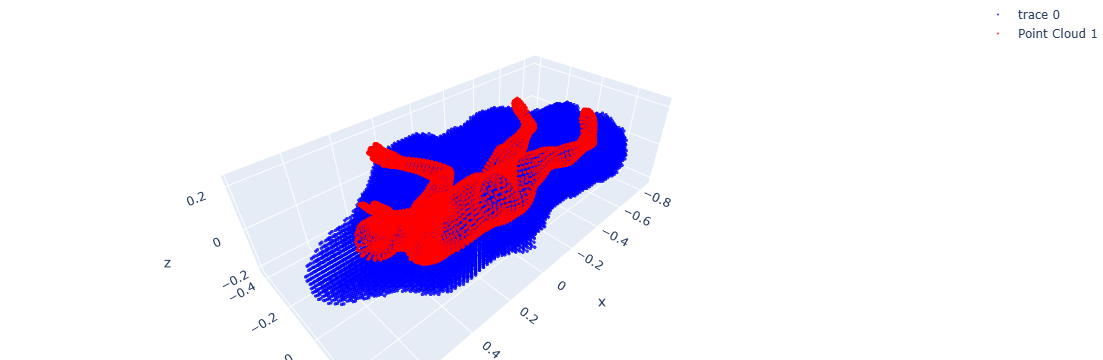

In [20]:
import numpy as np
import plotly.graph_objects as go

# Your point cloud: shape (N, 3)
point_cloud = voxels_centers_nearsurface_important#np.random.randn(10000, 3)
pc1 = verts[100]
# Split into x, y, z for Plotly
x, y, z = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]
x1, y1, z1 = pc1[:, 0], pc1[:, 1], pc1[:, 2]
# Create a 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,
            color='blue',  # or use scalar values here for colormap
            opacity=0.8
        )
    ),
    go.Scatter3d(
        x=x1, y=y1, z=z1,
        mode='markers',
        marker=dict(size=2, color='red', opacity=0.8),
        name='Point Cloud 1'
    )
])

# Layout for better aspect ratio
fig.update_layout(
    scene=dict(aspectmode='data'),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()


In [21]:
pc_smal = np.load("PointCloudUDFFromPoitCloud.npz")['arr_0'][:8000]

In [22]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm
M = pc_smal.shape[0]
N_voxels = voxels_centers_nearsurface_important.shape[0]

udf_dataset = np.zeros((M, N_voxels), dtype=np.float32)

for i in tqdm(range(M)):
    pc = pc_smal[i]  # shape: (12000, 3)
    
    # Build KD-tree for this point cloud
    kdtree = cKDTree(pc)
    
    # Query the closest distance from each voxel center to the point cloud
    distances, _ = kdtree.query(voxels_centers_nearsurface_important, k=1)
    
    # Store UDF
    udf_dataset[i] = distances.astype(np.float32)


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [03:19<00:00, 40.17it/s]


In [23]:
pc_surreal = np.load("SurrealPointCloudUDFFromPoitCloud.npz")['arr_0'][:8000]

In [24]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm
M = pc_surreal.shape[0]
N_voxels = voxels_centers_nearsurface_important.shape[0]

udf_dataset_surreal = np.zeros((M, N_voxels), dtype=np.float32)

for i in tqdm(range(M)):
    pc = pc_surreal[i]  # shape: (12000, 3)
    
    # Build KD-tree for this point cloud
    kdtree = cKDTree(pc)
    
    # Query the closest distance from each voxel center to the point cloud
    distances, _ = kdtree.query(voxels_centers_nearsurface_important, k=1)
    
    # Store UDF
    udf_dataset_surreal[i] = distances.astype(np.float32)


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:57<00:00, 45.04it/s]


In [25]:
#pc_all = pts_all
smaltrainidx = np.load("TrainIndexPairs.npy")
smaltrainidx = smaltrainidx[np.where(smaltrainidx < 8000)]

surrealtrainidx = np.load("SurrealTrainIndexPairs.npy")
udf_dataset_train = np.concatenate((udf_dataset_surreal[surrealtrainidx], udf_dataset[smaltrainidx]), axis =0 )
print(udf_dataset_train.shape)

(15590, 30672)


In [26]:
from sklearn.decomposition import  IncrementalPCA, PCA

n_components = 400
ipca = PCA(n_components=n_components)
#n = voxels_all_train.shape[0]
#chunk_size = 4000
#for i in range(0, n//chunk_size):
#    ipca.partial_fit(voxels_all_train[i*chunk_size : (i+1)*chunk_size])
ipca.fit(udf_dataset_train)

PCA(n_components=400)

In [27]:
np.cumsum(ipca.explained_variance_ratio_)[:400]

array([0.2861194 , 0.41514874, 0.514396  , 0.572616  , 0.6155151 ,
       0.6519758 , 0.6867081 , 0.71432924, 0.7416086 , 0.7606746 ,
       0.7771916 , 0.7921448 , 0.8038371 , 0.81487244, 0.82311237,
       0.83057654, 0.8376733 , 0.8445008 , 0.85112715, 0.85685074,
       0.8621984 , 0.8668952 , 0.87137157, 0.87572396, 0.87984544,
       0.8837659 , 0.8874972 , 0.89107877, 0.8943999 , 0.89768183,
       0.90078056, 0.90353763, 0.9061108 , 0.9084952 , 0.91072816,
       0.912832  , 0.9148599 , 0.9168741 , 0.9187937 , 0.92055285,
       0.9222336 , 0.92391026, 0.925493  , 0.9270451 , 0.92854613,
       0.93000644, 0.93142927, 0.93277556, 0.93408275, 0.9353809 ,
       0.9366284 , 0.9377752 , 0.9388483 , 0.93990207, 0.9409328 ,
       0.9419421 , 0.94286656, 0.9437621 , 0.9446195 , 0.94546396,
       0.9462844 , 0.94710153, 0.94787574, 0.94863737, 0.9493606 ,
       0.9500728 , 0.95077425, 0.9514703 , 0.95215017, 0.9528168 ,
       0.95347744, 0.9540931 , 0.95469874, 0.9552857 , 0.95583

In [28]:
pca_udf_dataset_all = ipca.transform(np.concatenate((udf_dataset_surreal, udf_dataset), axis =0 ))
pca_udf_dataset_train = ipca.transform(udf_dataset_train)

In [29]:
np.save("PCA_SMALSurrealPointCloudUDF_dense_rot_center_cleannoise_all_0_12fil.npy",pca_udf_dataset_all)

In [30]:
import pickle

# Save
with open('pca_model_PointCloudUDF_SMALSURREAL_0_12fil.pkl', 'wb') as f:
    pickle.dump(ipca, f)

# Load
with open('pca_model_PointCloudUDF_SMALSURREAL_0_12fil.pkl', 'rb') as f:
    pca_loaded = pickle.load(f)
